In [1]:
import torch
import random
from torch_geometric.data import Data, Dataset
import networkx as nx
import numpy as np 
import matplotlib.pyplot as plt

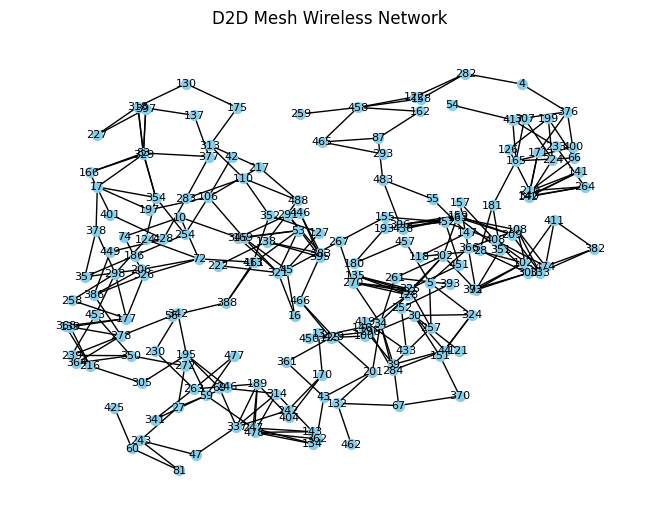

Number of nodes after discarding isolated nodes and keeping largest subgraph: 185


In [2]:

network_size = (100, 100)
num_nodes = 500

# Create a D2D mesh wireless network
G = nx.Graph()

# Add nodes with features
for i in range(num_nodes):
    position = (np.random.uniform(0, network_size[0]), np.random.uniform(0, network_size[1]))
    battery = np.random.uniform(0.8, 1)
    cpu = np.random.uniform(0.1, 1)
    memory = np.random.uniform(0.1, 1)
    bandwidth = np.random.uniform(10, 100) #MHz
    transmission_power = np.random.uniform(0.9, 1.2) # normally ~1mW

    G.add_node(i,
               position=position,
               battery=battery,
               cpu=cpu,
               memory=memory,
               bandwidth=bandwidth,
               transmission_power=transmission_power)

# Implement edge creation criteria
for node1 in G.nodes():
    for node2 in G.nodes():
        if node1 < node2:  # Avoid duplicate edges and self-loops
            dist = np.sqrt((G.nodes[node1]['position'][0] - G.nodes[node2]['position'][0])**2 +
                           (G.nodes[node1]['position'][1] - G.nodes[node2]['position'][1])**2)
            signal_strength = G.nodes[node1]['transmission_power'] / (dist**2)
            if 10 < dist < 50 and signal_strength > 0.008 and G.degree[node1] < 5 and G.degree[node2] < 5 and \
                    all(G.nodes[node]['battery'] > 0.3 for node in (node1, node2)) and \
                    all(G.nodes[node]['cpu'] < 0.8 for node in (node1, node2)) and \
                    all(G.nodes[node]['memory'] < 0.8 for node in (node1, node2)):
                G.add_edge(node1, node2)

# Discard nodes without neighbors
isolated_nodes = [node for node in G.nodes() if G.degree(node) <=1]
G.remove_nodes_from(isolated_nodes)

# Keep only the largest subgraph
largest_subgraph_nodes = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_subgraph_nodes)


# Plot the graph based on position_x and position_y
pos = {node: G.nodes[node]['position'] for node in G.nodes()}
nx.draw(G, pos, with_labels=True, node_size=50, node_color='skyblue', font_size=8)
plt.title("D2D Mesh Wireless Network")
plt.show()

# Print the resulting number of nodes
print(f"Number of nodes after discarding isolated nodes and keeping largest subgraph: {G.number_of_nodes()}")

In [3]:
def update_node_attributes(G):
    decay_amount = 0.1 # How much the battery drains for every neighbor
    utilization_amount = 0.1 # How much the cpu/memory is utilized for every neighbor
    for node in G.nodes():
        # Simulate changes in node attributes
        if G.nodes[node]['battery'] > 0.3:
            G.nodes[node]['battery'] = G.nodes[node]['battery'] - np.random.uniform(0, G.degree[node] * decay_amount)
        else:
            G.nodes[node]['battery'] = np.random.uniform(0.8, 1)
        G.nodes[node]['cpu'] = np.random.uniform(G.degree[node] * utilization_amount, 1)
        G.nodes[node]['memory'] = np.random.uniform(G.degree[node] * utilization_amount, 1)

        # Ensure attributes stay within bounds
        G.nodes[node]['battery'] = max(min(G.nodes[node]['battery'], 1), 0)
        G.nodes[node]['cpu'] = max(min(G.nodes[node]['cpu'], 1), 0)
        G.nodes[node]['memory'] = max(min(G.nodes[node]['memory'], 1), 0)

    return G


def update_edge_dynamics(G):
    b,c,p = 0,0,0
    # Consider all possible pairs of nodes
    for node1 in G.nodes():
        for node2 in G.nodes():
            if node1 < node2:
                # Calculate distance and signal strength
                dist = np.linalg.norm(np.array(G.nodes[node1]['position']) - np.array(G.nodes[node2]['position']))
                signal_strength = G.nodes[node1]['transmission_power'] / (dist**2)

                # Check the updated criteria for forming an edge
                if not G.has_edge(node1, node2):
                    if 10 < dist < 50 and signal_strength > 0.008 and G.degree[node1] < 5 and G.degree[node2] < 5 and \
                        all(G.nodes[node]['battery'] > 0.1 for node in (node1, node2)) and \
                        all(G.nodes[node]['cpu'] < 0.8 for node in (node1, node2)) and \
                        all(G.nodes[node]['memory'] < 0.8 for node in (node1, node2)):
                        # If it doesn't exist, add the edge
                        G.add_edge(node1, node2)
                        p += 1

                if G.has_edge(node1, node2) and G.degree[node1] > 1 and G.degree[node2] > 1:
                # Additional condition to remove an edge if it no longer meets criteria
                # Make sure that removing this edge will not result in an isolated node
                    if any(G.nodes[node]['battery'] < 0.3 for node in (node1, node2)):
                        G.remove_edge(node1, node2)
                        b += 1
                        if not nx.is_connected(G):
                            G.add_edge(node1, node2)
                            b -= 1

                    elif any(G.nodes[node]['cpu'] > 0.95 for node in (node1, node2)) and \
                        any(G.nodes[node]['memory'] > 0.95 for node in (node1, node2)):
                        G.remove_edge(node1, node2)
                        c += 1
                        if not nx.is_connected(G):
                            G.add_edge(node1, node2)
                            c -= 1

    
    return G


In [4]:
num_snapshots = 30

snapshots = []
# Create a copy of the graph for modifications
G_temp = G.copy()

snapshots.append(G_temp)

for j in range(num_snapshots):
    print(f"Iteration: {j}, # of edges: {G_temp.number_of_edges()}, # of nodes: {G_temp.number_of_nodes()}")
    G_temp = snapshots[-1].copy()

    # Update node attributes
    update_node_attributes(G_temp)


    # Update edge dynamics on the temporary graph
    update_edge_dynamics(G_temp)
    if G_temp.number_of_edges() < G.number_of_edges() / 10:
        break


    # Remove isolated nodes from the temporary graph
    isolated_nodes = [node for node in G_temp.nodes() if G_temp.degree(node) == 0]
    G_temp.remove_nodes_from(isolated_nodes)

    # Keep only the largest connected component in the temporary graph
    if not nx.is_connected(G_temp):
        largest_subgraph_nodes = max(nx.connected_components(G_temp), key=len)
        G_temp = G_temp.subgraph(largest_subgraph_nodes).copy()

    # Add the modified temporary graph to snapshots
    snapshots.append(G_temp)




Iteration: 0, # of edges: 282, # of nodes: 185
b, c, p : ((0, 5, 0))
Iteration: 1, # of edges: 277, # of nodes: 185
b, c, p : ((38, 2, 3))
Iteration: 2, # of edges: 240, # of nodes: 185


b, c, p : ((53, 1, 12))
Iteration: 3, # of edges: 198, # of nodes: 185
b, c, p : ((42, 0, 47))
Iteration: 4, # of edges: 203, # of nodes: 185
b, c, p : ((22, 1, 27))
Iteration: 5, # of edges: 207, # of nodes: 185
b, c, p : ((27, 3, 35))
Iteration: 6, # of edges: 212, # of nodes: 185
b, c, p : ((29, 1, 17))
Iteration: 7, # of edges: 199, # of nodes: 185
b, c, p : ((24, 0, 24))
Iteration: 8, # of edges: 199, # of nodes: 185
b, c, p : ((25, 1, 33))
Iteration: 9, # of edges: 206, # of nodes: 185
b, c, p : ((26, 3, 36))
Iteration: 10, # of edges: 213, # of nodes: 185
b, c, p : ((35, 0, 28))
Iteration: 11, # of edges: 206, # of nodes: 185
b, c, p : ((35, 2, 28))
Iteration: 12, # of edges: 197, # of nodes: 185
b, c, p : ((23, 1, 25))
Iteration: 13, # of edges: 198, # of nodes: 185
b, c, p : ((25, 1, 22))
Iteration: 14, # of edges: 194, # of nodes: 185
b, c, p : ((20, 1, 30))
Iteration: 15, # of edges: 203, # of nodes: 185
b, c, p : ((33, 0, 39))
Iteration: 16, # of edges: 209, # of nodes: 185

In [5]:

def extractFeatures(G):
    from torch_geometric.utils import from_networkx

   
    batteries = [G.nodes[node]['battery'] for node in G.nodes()]
    cpus = [G.nodes[node]['cpu'] for node in G.nodes()]
    memories = [G.nodes[node]['memory'] for node in G.nodes()]
    

    #Convert lists to tensors
    
    batteries_tensor = torch.tensor(batteries, dtype=torch.float32).view(-1, 1)
    cpus_tensor = torch.tensor(cpus, dtype=torch.float32).view(-1, 1)
    memories_tensor = torch.tensor(memories, dtype=torch.float32).view(-1, 1)


    #Concatenate tensors to get the node feature tensor
    x = torch.cat([batteries_tensor, cpus_tensor, memories_tensor], dim=1)
    
   
    data = from_networkx(G)
    attributes_to_remove = ['position', 'battery', 'cpu', 'memory', 'bandwidth', 'transmission_power', 'num_nodes']

    for attr in attributes_to_remove:
        if hasattr(data, attr):
            delattr(data, attr)

    data.x = x
    data.y = torch.tensor([1 if (node_features[0] < 0.35 or node_features[1] > 0.75 or node_features[2] > 0.75) else 0 for node_features in data.x])
    
    edge_index = data.edge_index
    return data



In [35]:
graphs = [ ]

for i in snapshots: 
    graphs.append(extractFeatures(i))

In [23]:
import torch
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
from torch_geometric.data import Data


import numpy as np

class MyDynamicGraphTemporalSignal(DynamicGraphTemporalSignal):
    def __init__(self, data_list, lags=4):
        """
        Initialize the custom dynamic graph temporal signal from a list of Data objects with lags.

        Args:
        - data_list (List[Data]): A list of PyTorch Geometric Data objects.
        - lags (int): The number of time lags to include in the features.
        """
        edge_indices = [data.edge_index.numpy() for data in data_list]
        edge_weights = [None] * len(data_list)  # Assuming no edge weights
        targets = []       # Assuming no targets

        # Initialize features list with lagged features
        features = [None] * len(data_list)

        for i in range(len(data_list)):
            # Collecting features from the current and previous snapshots
            lagged_features = []
            for j in range(lags):
                idx = i - j
                if idx >= 0:
                    lagged_features.append(data_list[idx].x.numpy())
                else:
                    # Handling cases with insufficient previous snapshots
                    lagged_features.append(np.zeros(data_list[0].x.shape))

            # Concatenate lagged features along the feature dimension
            features[i] = np.concatenate(lagged_features, axis=1)
            targets.append(data_list[i].y.numpy())

        super(MyDynamicGraphTemporalSignal, self).__init__(edge_indices, edge_weights, features, targets)


dataset  = MyDynamicGraphTemporalSignal(graphs)
dataset[0]

Data(x=[185, 12], edge_index=[2, 564], y=[185])

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [42]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.signal import temporal_signal_split

epochs = 30
train_ratio = 0.8
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=train_ratio)
train_dataset_lenth = int(len(graphs)*train_ratio)
model = RecurrentGCN(node_features = 12)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_function = torch.nn.BCEWithLogitsLoss()  

for epoch in range(epochs):  
    model.train()
    total_loss = 0
    for index, snapshot in enumerate(train_dataset):
        optimizer.zero_grad()
        x, edge_index, edge_weight, y = snapshot.x, snapshot.edge_index, snapshot.edge_weight, snapshot.y.float()  
        out = model(x, edge_index, edge_weight).squeeze()  
        loss = loss_function(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / train_dataset_lenth
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for snapshot in test_dataset:
        x, edge_index, edge_weight, y = snapshot.x, snapshot.edge_index, snapshot.edge_weight, snapshot.y.float()
        out = model(x, edge_index, edge_weight).squeeze()  
        predictions = torch.sigmoid(out) >= 0.5
        correct += predictions.eq(y).sum().item()
        total += y.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/30, Loss: 0.6228
Epoch 2/30, Loss: 0.6138
Epoch 3/30, Loss: 0.4716
Epoch 4/30, Loss: 0.4220
Epoch 5/30, Loss: 0.3875
Epoch 6/30, Loss: 0.3912
Epoch 7/30, Loss: 0.3902
Epoch 8/30, Loss: 0.3756
Epoch 9/30, Loss: 0.3709
Epoch 10/30, Loss: 0.3717
Epoch 11/30, Loss: 0.4102
Epoch 12/30, Loss: 0.3686
Epoch 13/30, Loss: 0.3939
Epoch 14/30, Loss: 0.3836
Epoch 15/30, Loss: 0.3937
Epoch 16/30, Loss: 0.3675
Epoch 17/30, Loss: 0.3586
Epoch 18/30, Loss: 0.3586
Epoch 19/30, Loss: 0.3546
Epoch 20/30, Loss: 0.3530
Epoch 21/30, Loss: 0.3546
Epoch 22/30, Loss: 0.3495
Epoch 23/30, Loss: 0.3572
Epoch 24/30, Loss: 0.3510
Epoch 25/30, Loss: 0.3665
Epoch 26/30, Loss: 0.3616
Epoch 27/30, Loss: 0.3683
Epoch 28/30, Loss: 0.3708
Epoch 29/30, Loss: 0.3832
Epoch 30/30, Loss: 0.3561
Test Accuracy: 0.8432
